# Exercise 02: Multi-class Classification 
In this exercise, you will train a deep model on the CIFAR10 from the scratch using PyTorch. The following tasks should be done:
- Task 1: per batch training/testing
- Task 2: Instance inference and visualization

### Basic Imports

In [77]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [78]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [80]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [81]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [82]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [83]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [84]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
###############################################################

In [85]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [86]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training

In [87]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0149 Acc: 0.2841
Begin test......
Test Loss: 0.0139 Acc: 0.3688
Epoch: 2/30 Train Loss: 0.0140 Acc: 0.3398
Begin test......
Test Loss: 0.0140 Acc: 0.3589
Epoch: 3/30 Train Loss: 0.0137 Acc: 0.3543
Begin test......
Test Loss: 0.0136 Acc: 0.3715
Epoch: 4/30 Train Loss: 0.0136 Acc: 0.3663
Begin test......
Test Loss: 0.0129 Acc: 0.4004
Epoch: 5/30 Train Loss: 0.0134 Acc: 0.3774
Begin test......
Test Loss: 0.0131 Acc: 0.3907
Epoch: 6/30 Train Loss: 0.0123 Acc: 0.4236
Begin test......
Test Loss: 0.0114 Acc: 0.4749
Epoch: 7/30 Train Loss: 0.0121 Acc: 0.4388
Begin test......
Test Loss: 0.0113 Acc: 0.4764
Epoch: 8/30 Train Loss: 0.0120 Acc: 0.4404
Begin test......
Test Loss: 0.0118 Acc: 0.4600
Epoch: 9/30 Train Loss: 0.0120 Acc: 0.4462
Begin test......
Test Loss: 0.0110 Acc: 0.4970
Epoch: 10/30 Train Loss: 0.0119 Acc: 0.4520
Begin test......
Test Loss: 0.0111 Acc: 0.5010
Epoch: 11/30 Train Loss: 0.0113 Acc: 0.4819
Begin test......
Test Loss: 0.0106 Acc: 0.5153
Epoch: 1

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [88]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

#### class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [89]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
model.eval()
with torch.no_grad():
    output = model(image)
probabilities = F.softmax(output,dim=1)
print(probabilities.shape)
print(probabilities)
predict_label = torch.argmax(probabilities,dim=1).cpu().numpy().tolist()
print(predict_label)


torch.Size([16, 10])
tensor([[5.2532e-03, 8.9569e-04, 1.4979e-01, 9.2289e-02, 9.9256e-02, 1.8048e-01,
         1.8301e-02, 4.5256e-01, 6.5235e-04, 5.2502e-04],
        [1.7206e-02, 8.2077e-02, 1.1327e-02, 1.2503e-01, 7.1519e-03, 1.3512e-01,
         1.3521e-02, 4.2931e-02, 2.6861e-02, 5.3878e-01],
        [5.0908e-01, 3.9458e-02, 2.5838e-02, 4.2246e-03, 3.0492e-02, 3.7263e-04,
         2.0148e-03, 2.1630e-03, 3.7216e-01, 1.4195e-02],
        [7.7828e-01, 4.0414e-02, 3.4663e-03, 3.5359e-04, 5.4019e-03, 4.4926e-05,
         2.9794e-04, 6.2290e-04, 1.5303e-01, 1.8097e-02],
        [1.2899e-01, 2.4262e-02, 3.6228e-04, 1.2383e-04, 4.0897e-04, 5.4149e-06,
         1.6010e-05, 8.1008e-05, 8.0704e-01, 3.8713e-02],
        [7.4943e-03, 3.0310e-04, 2.1941e-01, 7.6548e-02, 5.7524e-01, 3.9638e-02,
         5.8459e-02, 2.1456e-02, 1.1371e-03, 3.1232e-04],
        [7.3808e-03, 1.4679e-03, 4.4840e-02, 2.4461e-01, 1.2585e-02, 3.7188e-01,
         1.2017e-02, 2.3322e-01, 6.8315e-02, 3.6919e-03],
      

In [47]:
a = [1,2,1]
b = ["a","b","c"]
c = [b[i] for i in a]
c

['b', 'c', 'b']

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


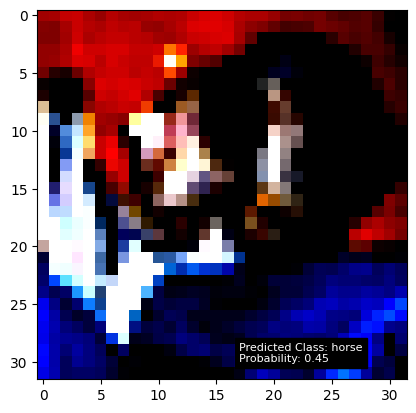

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0053
automobile: 0.0009
bird: 0.1498
cat: 0.0923
deer: 0.0993
dog: 0.1805
frog: 0.0183
horse: 0.4526
ship: 0.0007
truck: 0.0005


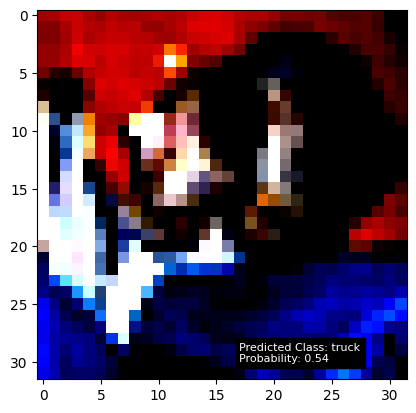

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0172
automobile: 0.0821
bird: 0.0113
cat: 0.1250
deer: 0.0072
dog: 0.1351
frog: 0.0135
horse: 0.0429
ship: 0.0269
truck: 0.5388


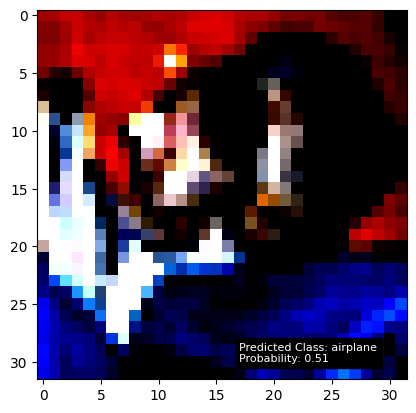

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.5091
automobile: 0.0395
bird: 0.0258
cat: 0.0042
deer: 0.0305
dog: 0.0004
frog: 0.0020
horse: 0.0022
ship: 0.3722
truck: 0.0142


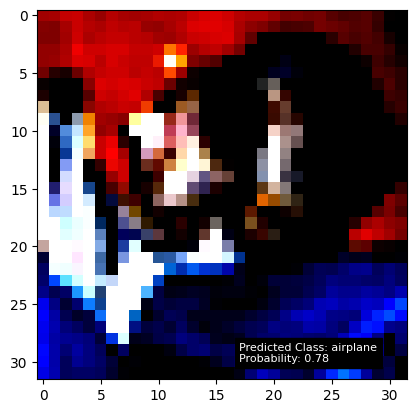

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.7783
automobile: 0.0404
bird: 0.0035
cat: 0.0004
deer: 0.0054
dog: 0.0000
frog: 0.0003
horse: 0.0006
ship: 0.1530
truck: 0.0181


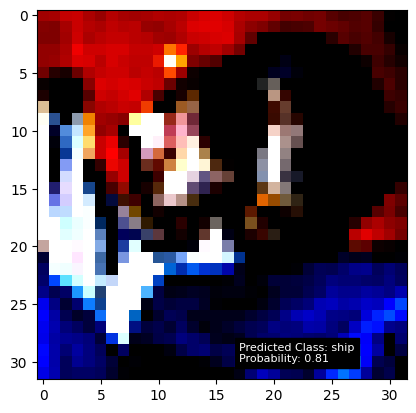

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.1290
automobile: 0.0243
bird: 0.0004
cat: 0.0001
deer: 0.0004
dog: 0.0000
frog: 0.0000
horse: 0.0001
ship: 0.8070
truck: 0.0387


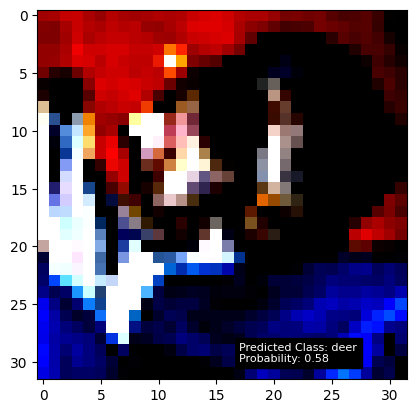

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0075
automobile: 0.0003
bird: 0.2194
cat: 0.0765
deer: 0.5752
dog: 0.0396
frog: 0.0585
horse: 0.0215
ship: 0.0011
truck: 0.0003


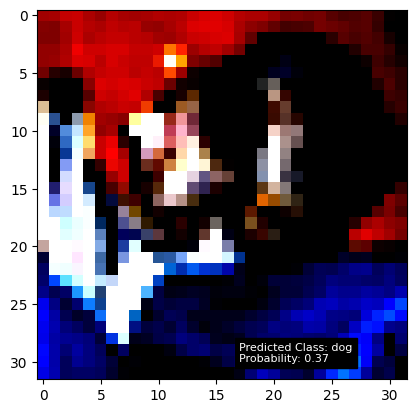

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0074
automobile: 0.0015
bird: 0.0448
cat: 0.2446
deer: 0.0126
dog: 0.3719
frog: 0.0120
horse: 0.2332
ship: 0.0683
truck: 0.0037


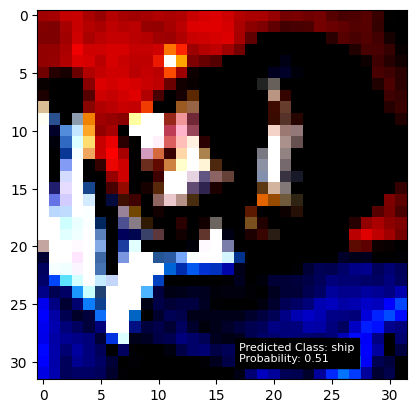

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.2675
automobile: 0.0708
bird: 0.0003
cat: 0.0000
deer: 0.0004
dog: 0.0000
frog: 0.0000
horse: 0.0000
ship: 0.5102
truck: 0.1508


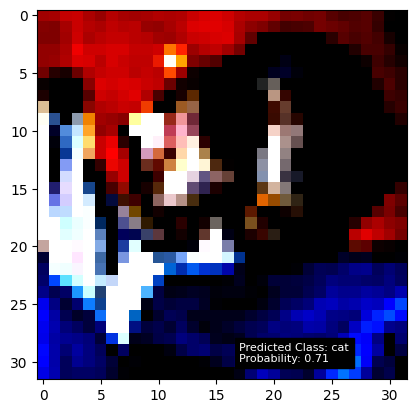

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0008
automobile: 0.0000
bird: 0.0259
cat: 0.7097
deer: 0.0075
dog: 0.1399
frog: 0.1027
horse: 0.0132
ship: 0.0001
truck: 0.0001


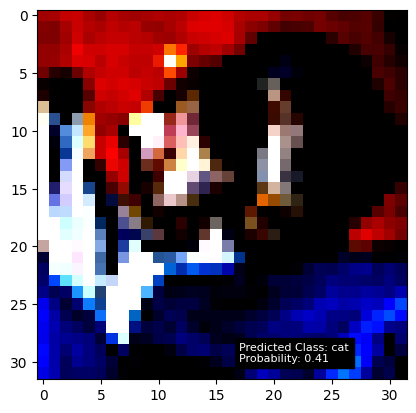

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0067
automobile: 0.0000
bird: 0.0185
cat: 0.4088
deer: 0.1432
dog: 0.2285
frog: 0.0034
horse: 0.1893
ship: 0.0014
truck: 0.0002


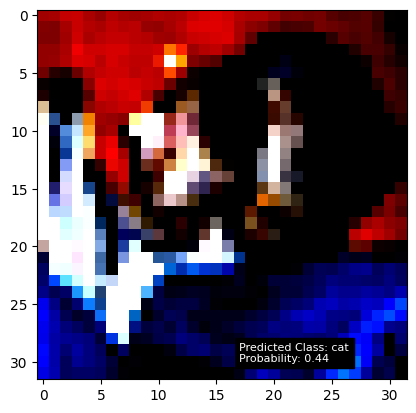

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0057
automobile: 0.0017
bird: 0.0492
cat: 0.4359
deer: 0.1195
dog: 0.2056
frog: 0.1136
horse: 0.0641
ship: 0.0025
truck: 0.0023


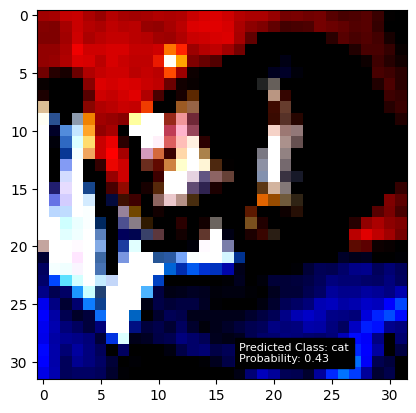

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0371
automobile: 0.0019
bird: 0.0326
cat: 0.4338
deer: 0.0348
dog: 0.3487
frog: 0.0030
horse: 0.0457
ship: 0.0578
truck: 0.0047


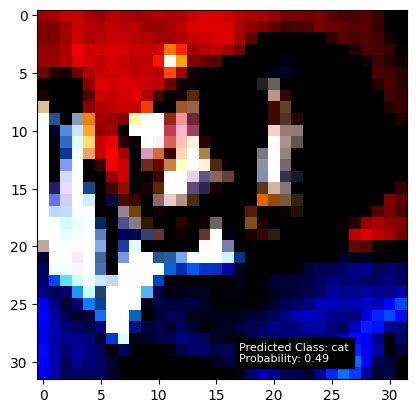

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0003
automobile: 0.0000
bird: 0.0399
cat: 0.4878
deer: 0.0556
dog: 0.2222
frog: 0.1796
horse: 0.0145
ship: 0.0000
truck: 0.0000


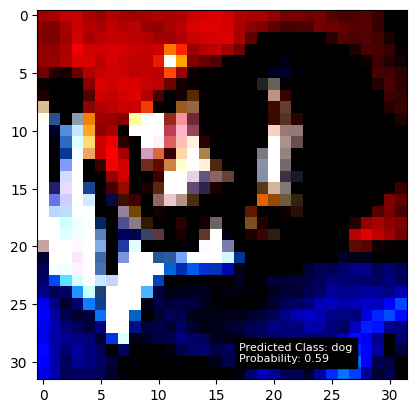

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0010
automobile: 0.0000
bird: 0.0350
cat: 0.2692
deer: 0.0068
dog: 0.5929
frog: 0.0161
horse: 0.0784
ship: 0.0003
truck: 0.0002


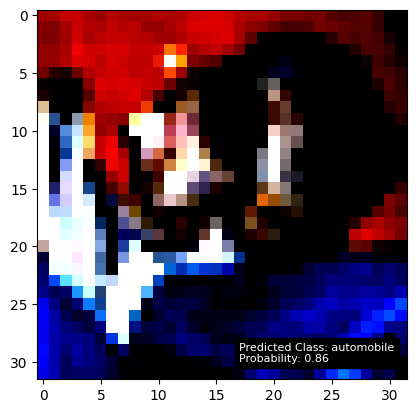

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Print probabilities for each class:
airplane: 0.0176
automobile: 0.8600
bird: 0.0193
cat: 0.0091
deer: 0.0071
dog: 0.0042
frog: 0.0142
horse: 0.0085
ship: 0.0044
truck: 0.0555


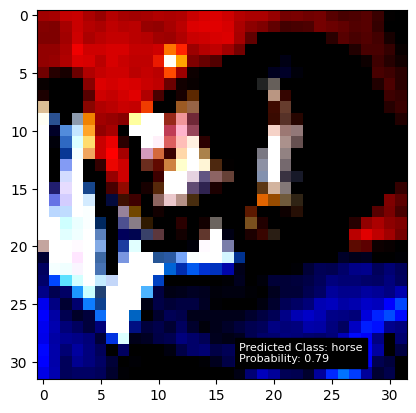

Print probabilities for each class:
airplane: 0.0029
automobile: 0.0005
bird: 0.0096
cat: 0.0247
deer: 0.1234
dog: 0.0358
frog: 0.0104
horse: 0.7893
ship: 0.0003
truck: 0.0030


In [91]:
for k in range(16):
    predicted_class = [class_names[j] for j in predict_label]
    predicted_probability = [probabilities[i][predict_label[i]] for i in range(16)]
    image = input.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.text(17, 30, f'Predicted Class: {predicted_class[k]}\nProbability: {predicted_probability[k]:.2f}', 
                color='white', backgroundcolor='black', fontsize=8)
    plt.show()

    # Print probabilities for each class
    print('Print probabilities for each class:')

    for i in range(len(class_names)):
        print(f'{class_names[i]}: {probabilities[k,i].item():.4f}')